**Import Libraries**

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**Load the dataset**

In [9]:
df = pd.read_csv('/content/loans_full_schema.csv')

In [10]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [11]:
df.shape

(10000, 55)

In [12]:
df.size

550000

In [13]:
df.columns

Index(['emp_title', 'emp_length', 'state', 'homeownership', 'annual_income',
       'verified_income', 'debt_to_income', 'annual_income_joint',
       'verification_income_joint', 'debt_to_income_joint', 'delinq_2y',
       'months_since_last_delinq', 'earliest_credit_line',
       'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines',
       'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m', 'num_historical_failed_to_pay',
       'months_since_90d_late', 'current_accounts_delinq',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_satisfactory_accounts', 'num_accounts_120d_past_due',
       'num_accounts_30d_past_due', 'num_active_debit_accounts',
       'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankr

In [15]:
# Convert loan_status to binary target
default_statuses = ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)']
df['target'] = df['loan_status'].apply(lambda x: 1 if x in default_statuses else 0)

In [16]:
df.drop(columns=['loan_status'], inplace=True)

In [17]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False).head(20)

,0
verification_income_joint,8545
annual_income_joint,8505
debt_to_income_joint,8505
months_since_90d_late,7715
months_since_last_delinq,5658
months_since_last_credit_inquiry,1271
emp_title,833
emp_length,817
num_accounts_120d_past_due,318
debt_to_income,24


In [20]:
# Fill out the missing values
# Fill numeric columns with median
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

In [21]:
# Fill categorical columns with mode
for col in df.select_dtypes(include='object').columns:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

**One-hot Encoding**

In [22]:
# Encode the categorical columns using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

**Split features and target**

In [23]:
X = df.drop('target', axis=1)
y = df['target']

**Standardization**

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Handle imbalance via SMOTE**

In [25]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

**`train_test_split`**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

**Train the LightGBM Model**

In [27]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 7955, number of negative: 7867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25842
[LightGBM] [Info] Number of data points in the train set: 15822, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502781 -> initscore=0.011124
[LightGBM] [Info] Start training from score 0.011124


LGBMClassifier(random_state=42)

**Model Prediction**

In [30]:
y_pred = model.predict(X_test)

**Model Evaluation**

In [31]:
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print(" Precision:", precision_score(y_test, y_pred))
print(" Recall:", recall_score(y_test, y_pred))
print(" F1 Score:", f1_score(y_test, y_pred))


 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2022
           1       1.00      0.99      1.00      1934

    accuracy                           1.00      3956
   macro avg       1.00      1.00      1.00      3956
weighted avg       1.00      1.00      1.00      3956

 Precision: 1.0
 Recall: 0.9943123061013444
 F1 Score: 0.9971480425200934


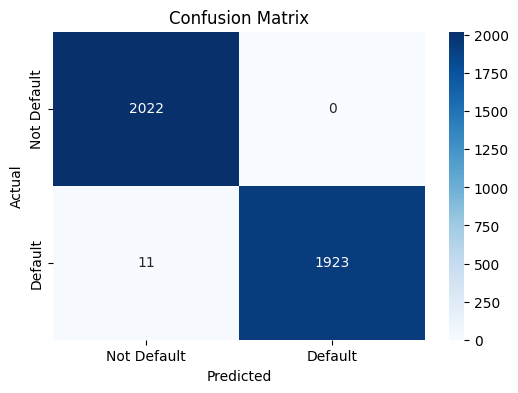

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Feature Importance**

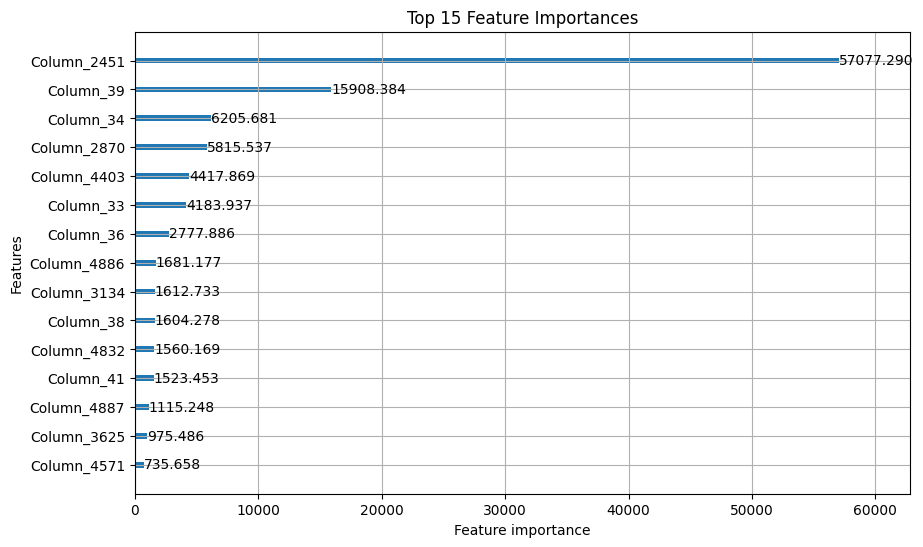

In [33]:
lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(10,6))
plt.title("Top 15 Feature Importances")
plt.show()